In [1]:
# This cell is used for creating a button that hides/unhides code cells to quickly look only the results.
# Works only with Jupyter Notebooks.

from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
# Description:
#   Exercise09 notebook.
#
# Copyright (C) 2018 Santiago Cortes, Juha Ylioinas
#
# This software is distributed under the GNU General Public 
# Licence (version 2 or later); please refer to the file 
# Licence.txt, included with the software, for details.

# Preparations
import os
import numpy as np
import matplotlib.pyplot as plt

from utils import from_data_file, theta_to_model, model_to_theta, initial_model, logistic, \
    log_sum_exp_over_rows, classification_performance

# Select data directory

if os.path.isdir('/coursedata'):
    # JupyterHub
    course_data_dir = '/coursedata'
elif os.path.isdir('../../../coursedata'):
    # Local installation
    course_data_dir = '../../../coursedata'
else:
    # Docker
    course_data_dir = '/home/jovyan/work/coursedata/'

print('The data directory is %s' % course_data_dir)
data_dir = os.path.join(course_data_dir, 'exercise-09-data')
print('Data stored in %s' % data_dir)

The data directory is /coursedata
Data stored in /coursedata/exercise-09-data


# CS-E4850 Computer Vision Exercise Round 9

The problems should be solved before the exercise session and solutions returned via
MyCourses. Upload the files: (1) a pdf file containing your written answers to Exercise
1, and (2) both the pdf and .ipynb versions of the notebook containing your answers
to Exercises 2 and 3. Scanned, **neatly** handwritten, solutions are ok for problem 1. If
possible, combine your pdf solution of Exercise 1 with the notebook pdf into a single pdf
and return that with the notebook .ipynb file.

Notice also that the last two problems
can be done without solving Exercise 1 since the solutions are already written out in the
subtasks of Exercise 1 (i.e. only the derivations are missing and asked in Exercise 1).

If you have not studied basics of neural networks in previous courses and the problem
context of these exercises is not clear, it may be helpful to check the slides of the first four
lectures of prof. Hinton’s course “Introduction to neural networks and machine learning”:  
http://www.cs.toronto.edu/~hinton/coursera_slides.html    
http://www.cs.toronto.edu/~hinton/coursera_lectures.html (lecture videos).

### Name: Aitor Urruticoechea
### Student Id: 101444219

## Exercise 1 - Neural  networks  and  backpropagation
This is a pen-&-paper problem. See Exercise09penandpaper.pdf for the questions.

## Exercise 2 - Image  classification  using  a  neural  network
The first exercise problem above gives the solution to Part 2 of the second programming
assignment of professor Hinton’s course “Introduction to neural networks and machine
learning”. The assignment and related material are available at
https://www.cs.toronto.edu/~tijmen/csc321/assignments/a2/.


Check out the contents of the above web page and complete
the programming task of Part 2 according to the instructions given there. The code template for the python version is below. The solution for the
pen and paper part of the task is already given above in __Exercise 1__. Hence, the programming part is
a relatively straightforward implementation and can be done without carrying out the
derivations since the results of the derivations are already given in __Exercise 1__ above.

In [3]:
def test_gradient(model, data, wd_coefficient):
    import sys
    base_theta = model_to_theta(model)
    h = 1e-2
    correctness_threshold = 1e-5
    analytic_gradient_struct = d_loss_by_d_model(model, data, wd_coefficient)

    analytic_gradient = model_to_theta(analytic_gradient_struct);
    if True in np.isnan(analytic_gradient) or True in np.isinf(analytic_gradient):
        sys.exit('Your gradient computation produced a NaN or infinity. That is an error.')
    # We want to test the gradient not for every element of theta, because that's a 
    # lot of work. Instead, we test for only a few elements. If there's an error, this 
    # is probably enough to find that error.
    # We want to first test the hid_to_class gradient, because that's most likely 
    # to be correct (it's the easier one).
    # Let's build a list of theta indices to check. We'll check 20 elements of 
    # hid_to_class, and 80 elements of input_to_hid (it's bigger than hid_to_class).
    input_to_hid_theta_size = model['input_to_hid'].size
    hid_to_class_theta_size = model['hid_to_class'].size
    big_prime = 1299721; # 1299721 is prime and thus ensures a somewhat random-like selection of indices.
    hid_to_class_indices_to_check = np.mod(big_prime * np.arange(20), hid_to_class_theta_size) \
                                        + input_to_hid_theta_size
    input_to_hid_indices_to_check = np.mod(big_prime * np.arange(80), input_to_hid_theta_size)
    a = hid_to_class_indices_to_check[np.newaxis,:]
    b = input_to_hid_indices_to_check[np.newaxis,:]
    indices_to_check = np.ravel(np.hstack((a,b)))

    for i in range(100):
        test_index = indices_to_check[i]
        analytic_here = analytic_gradient[test_index]
        theta_step = base_theta * 0
        theta_step[test_index] = h
        contribution_distances = np.array([-4.,  -3.,  -2.,  -1.,   1.,   2.,   3.,   4.])
        contribution_weights = np.array([1/280., -4/105., 1/5., -4/5., 4/5., -1/5., 4/105., -1/280.])
        temp = 0;
        for contribution_index in range(8):
            temp = temp + loss(theta_to_model(base_theta + theta_step * \
                                              contribution_distances[contribution_index]), data, wd_coefficient) * \
                                                contribution_weights[contribution_index]
        fd_here = temp / h
        diff = np.abs(analytic_here - fd_here)
        
        if True in (diff > correctness_threshold) and \
            True in (diff / (np.abs(analytic_here) + np.abs(fd_here)) > correctness_threshold):
            part_names = ['input_to_hid', 'hid_to_class']
            sys.exit('Theta element #{} (part of {}), with value {}, has finite difference gradient {} but analytic gradient {}. That looks like an error.\n'.format(test_index, part_names[(i<20)], base_theta[test_index], fd_here, analytic_here))
        if i==19: 
            print('Gradient test passed for hid_to_class. ')
        if i==99: 
            print('Gradient test passed for input_to_hid. ')
    print('Gradient test passed. That means that the gradient that your code computed is within 0.001%% of the gradient that the finite difference approximation computed, so the gradient calculation procedure is probably correct (not certainly, but probably).\n')
    
def forward_pass(model, data):
    # This function does the forward pass through the network: calculating the states of all units, and some related data. 
    # This function is used in functions loss() and d_loss_by_d_model().  
  
    # model.input_to_hid is a matrix of size <number of hidden units> by <number of inputs i.e. 256>. It contains the weights from the input units to the hidden units.
    # model.hid_to_class is a matrix of size <number of classes i.e. 10> by <number of hidden units>. It contains the weights from the hidden units to the softmax units.
    # data.inputs is a matrix of size <number of inputs i.e. 256> by <number of data cases>. Each column describes a different data case. 
    # data.targets is a matrix of size <number of classes i.e. 10> by <number of data cases>. Each column describes a different data case. It contains a one-of-N encoding of the class, i.e. one element in every column is 1 and the others are 0.
    
    hid_input = np.dot(model['input_to_hid'], data['inputs']) # input to the hidden units, i.e. before the logistic. size: <number of hidden units> by <number of data cases>
    hid_output = logistic(hid_input) # output of the hidden units, i.e. after the logistic. size: <number of hidden units> by <number of data cases>
    class_input = np.dot(model['hid_to_class'], hid_output) # input to the components of the softmax. size: <number of classes, i.e. 10> by <number of data cases>
  
    # The following three lines of code implement the softmax.
    # However, it's written differently from what the lectures say.
    # In the lectures, a softmax is described using an exponential divided by a sum of exponentials.
    # What we do here is exactly equivalent (you can check the math or just check it in practice), but this is more numerically stable. 
    # "Numerically stable" means that this way, there will never be really big numbers involved.
    # The exponential in the lectures can lead to really big numbers, which are fine in mathematical equations, but can lead to all sorts of problems in Matlab
    # Matlab isn't well prepared to deal with really large numbers, like the number 10 to the power 1000. Computations with such numbers get unstable, so we avoid them.

    class_normalizer = log_sum_exp_over_rows(class_input) # log(sum(exp of class_input)) is what we subtract to get properly normalized log class probabilities. size: <1> by <number of data cases>
    log_class_prob = class_input - np.tile(class_normalizer, (class_input.shape[0], 1)) # log of probability of each class. size: <number of classes, i.e. 10> by <number of data cases>
    class_prob = np.exp(log_class_prob) # probability of each class. Each column (i.e. each case) sums to 1. size: <number of classes, i.e. 10> by <number of data cases>

    return hid_input, hid_output, class_input, log_class_prob, class_prob

def loss(model, data, wd_coefficient):
    hid_input, hid_output, class_input, log_class_prob, class_prob = forward_pass(model, data);
    classification_loss = -np.mean(np.sum(np.multiply(log_class_prob, data['target']), 0)) # select the right log class probability using that sum; then take the mean over all data cases.
    wd_loss = (np.sum(np.ravel(model['input_to_hid']) ** 2 ) + np.sum(np.ravel(model['hid_to_class']) ** 2 )) / 2. * wd_coefficient; # weight decay loss. very straightforward: E = 1/2 * wd_coeffecient * parameters^2
    ret = classification_loss + wd_loss
    return ret  

In [4]:
def d_loss_by_d_model(model, data, wd_coefficient):
    # model.input_to_hid is a matrix of size <number of hidden units> by <number of inputs i.e. 256>
    # model.hid_to_class is a matrix of size <number of classes i.e. 10> by <number of hidden units>
    # data.inputs is a matrix of size <number of inputs i.e. 256> by <number of data cases>
    # data.targets is a matrix of size <number of classes i.e. 10> by <number of data cases>

    # The returned object <ret> is supposed to be exactly like parameter <model>, i.e. it has fields ret.input_to_hid and ret.hid_to_class, and those are of the same shape as they are in <model>.
    # However, in <ret>, the contents of those matrices are gradients (d loss by d weight), instead of weights.
    ret = dict()
    # This is the only function that you're expected to change. Right now, it just returns a lot of zeros, which is obviously not the correct output. Your job is to change that.
    #--your-code-starts-here--#

    # Forward pass
    hid_input, hid_output, class_input, log_class_prob, class_prob = forward_pass(model, data)
    
    # Error signal output layer
    output_error = class_prob - data['target'] 
    
    # Gradient
    ret['hid_to_class'] = np.dot(output_error, hid_output.T) / data['inputs'].shape[1]
    
    # Error signal hidden layer
    def logistic_derivative(hid_input):
        hid_output = logistic(hid_input)
        return hid_output * (1 - hid_output)
    hidden_error = np.dot(model['hid_to_class'].T, output_error) * logistic_derivative(hid_input)
    
    # Gradient
    ret['input_to_hid'] = np.dot(hidden_error, data['inputs'].T) / data['inputs'].shape[1]
    
    # Weight decay
    ret['hid_to_class'] += wd_coefficient * model['hid_to_class']
    ret['input_to_hid'] += wd_coefficient * model['input_to_hid']

    return ret
    #--your-code-ends-here--#
    return ret

In [5]:
def a2(wd_coefficient, n_hid, n_iters, learning_rate, momentum_multiplier, do_early_stopping, mini_batch_size):
    model = initial_model(n_hid)
    datas = from_data_file(data_dir)

    n_training_cases = datas['train']['inputs'].shape[1]
    if n_iters != 0:
        print("Now testing the gradient on the whole training set...")
        test_gradient(model, datas['train'], wd_coefficient)
    
    # optimization
    training_batch = dict()
    best_so_far = dict()
    theta = model_to_theta(model)
    momentum_speed = theta * 0.
    training_data_losses = []
    validation_data_losses = []
    if do_early_stopping:
        best_so_far['theta'] = -1 # this will be overwritten soon
        best_so_far['validation_loss'] = np.Inf
        best_so_far['after_n_iters'] = -1
        
    for optimization_iteration_i in range(1, n_iters+1):
        model = theta_to_model(theta)
        training_batch_start = np.mod((optimization_iteration_i-1) * mini_batch_size, n_training_cases);  
        training_batch['inputs'] = datas['train']['inputs'][:, training_batch_start : training_batch_start + mini_batch_size]
        training_batch['target'] = datas['train']['target'][:, training_batch_start : training_batch_start + mini_batch_size]
        gradient = model_to_theta(d_loss_by_d_model(model, training_batch, wd_coefficient))
        momentum_speed = np.multiply(momentum_speed, momentum_multiplier) - gradient;
        theta = theta + momentum_speed * learning_rate;
        model = theta_to_model(theta);
        training_data_losses.append(loss(model, datas['train'], wd_coefficient))
        validation_data_losses.append(loss(model, datas['val'], wd_coefficient))
        
        if do_early_stopping and validation_data_losses[-1] < best_so_far['validation_loss']:
            best_so_far['theta'] = theta; # this will be overwritten soon
            best_so_far['validation_loss'] = validation_data_losses[-1]
            best_so_far['after_n_iters'] = optimization_iteration_i
            
        if np.mod(optimization_iteration_i, np.round(n_iters / 10.)) == 0:
            print('After {} optimization iterations, training data loss is {}, and validation data loss is {}\n'.format(optimization_iteration_i, training_data_losses[-1], validation_data_losses[-1]))
    
        if optimization_iteration_i == n_iters: # check gradient again, this time with more typical parameters and with a different data size
            print('Now testing the gradient on just a mini-batch instead of the whole training set... ')
            test_gradient(model, training_batch, wd_coefficient)
            
    if do_early_stopping:
        print('Early stopping: validation loss was lowest after {} iterations. We chose the model that we had then.\n'.format(best_so_far['after_n_iters']))
        theta = best_so_far['theta']
    
    # the optimization is finished. Now do some reporting.
    model = theta_to_model(theta)
    if n_iters != 0:
        ax = plt.figure(1, figsize=(15,10))
        plt.plot(training_data_losses, 'b')
        plt.plot(validation_data_losses, 'r')
        plt.tick_params(labelsize=25)
        ax.legend(('training', 'validation'), fontsize=25)
        plt.ylabel('loss', fontsize=25);
        plt.xlabel('iteration number', fontsize=25);
        plt.show()
    
    datas2 = [datas['train'], datas['val'], datas['test']]
    data_names = ['training', 'validation', 'test'];
    for data_i in range(3):
        data = datas2[data_i]
        data_name = data_names[data_i]
        print('\nThe total loss on the {} data is {}\n'.format(data_name, loss(model, data, wd_coefficient)))
        print('The classification loss (i.e. without weight decay) on the {} data is {}\n'.format(data_name, loss(model, data, 0)));
        print('The classification error rate on the {} data is {}\n'.format(data_name, classification_performance(model, data)))

    

Now testing the gradient on the whole training set...
Gradient test passed for hid_to_class. 
Gradient test passed for input_to_hid. 
Gradient test passed. That means that the gradient that your code computed is within 0.001%% of the gradient that the finite difference approximation computed, so the gradient calculation procedure is probably correct (not certainly, but probably).

After 3 optimization iterations, training data loss is 2.3025673934869757, and validation data loss is 2.3025008278520307

After 6 optimization iterations, training data loss is 2.3024876530303207, and validation data loss is 2.3024208773255115

After 9 optimization iterations, training data loss is 2.3024106986962787, and validation data loss is 2.302340149057484

After 12 optimization iterations, training data loss is 2.3023537336404405, and validation data loss is 2.3022851476944663

After 15 optimization iterations, training data loss is 2.3022741261667745, and validation data loss is 2.302203842915163

A

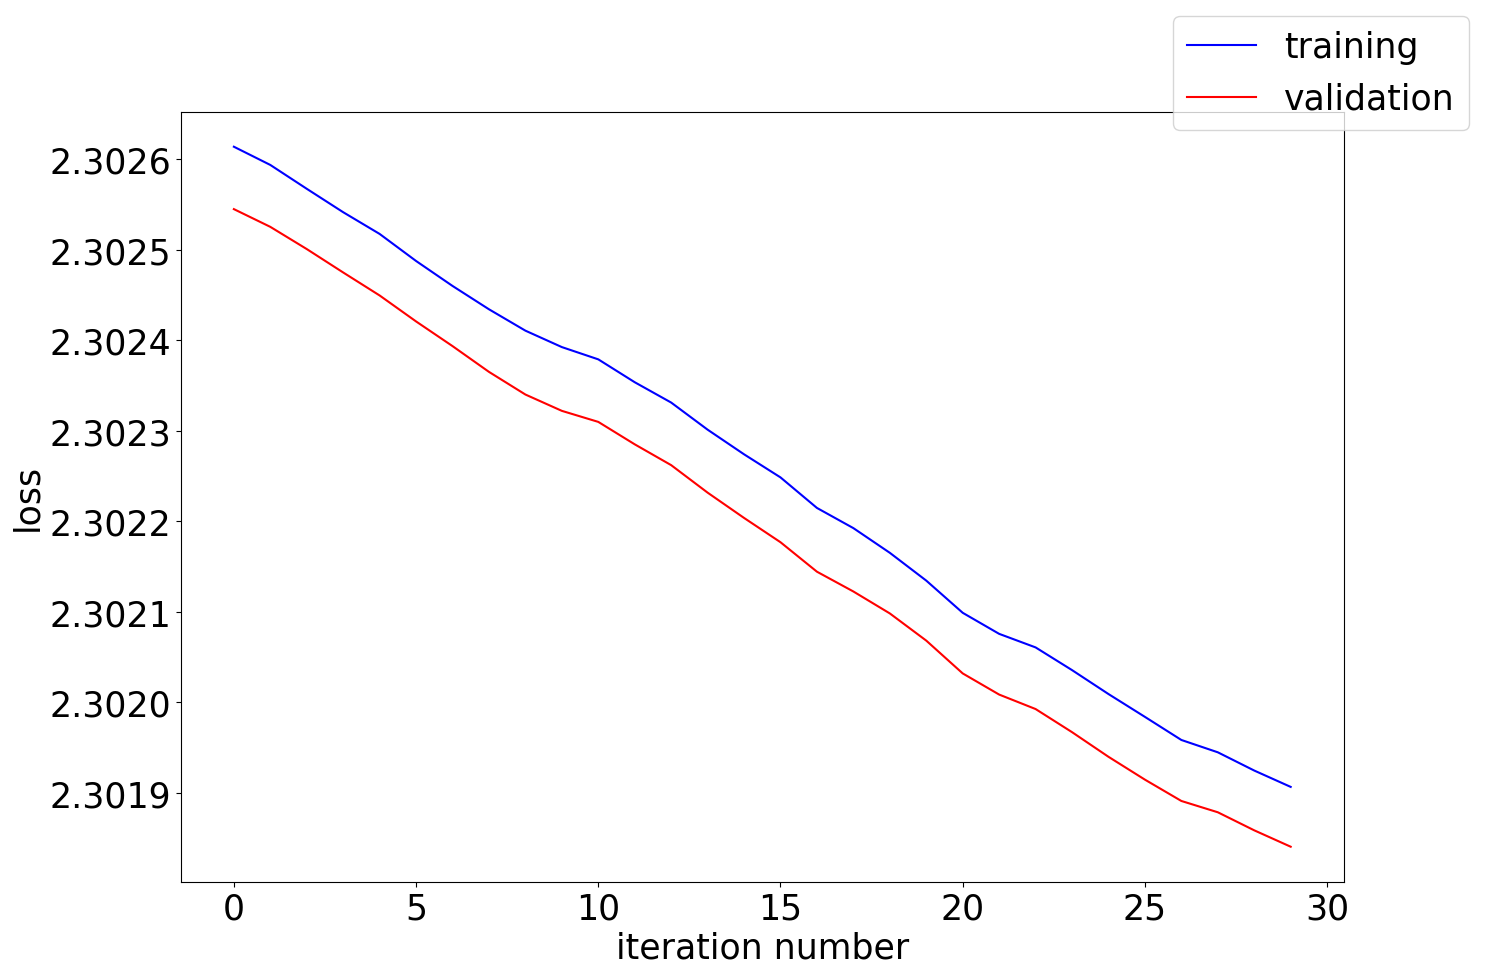


The total loss on the training data is 2.301906765216956

The classification loss (i.e. without weight decay) on the training data is 2.301906765216956

The classification error rate on the training data is 0.889


The total loss on the validation data is 2.301840691197619

The classification loss (i.e. without weight decay) on the validation data is 2.301840691197619

The classification error rate on the validation data is 0.895


The total loss on the test data is 2.3018651012099185

The classification loss (i.e. without weight decay) on the test data is 2.3018651012099185

The classification error rate on the test data is 0.8873333333333333



In [6]:
# Start training the neural network
#a2(0, 10, 70, 20.0, 0, False, 4) 
a2(0, 10, 30, 0.01, 0, False, 10)

When you have completed the programming part, run a2(0, 10, 30, 0.01, 0, False, 10) and report the resulting training data classification loss here:

Training data classification loss: 2.3019

## Exercise 3 - Optimisation using backpropagation
Do Part 3 of the assignment as described at
http://www.cs.toronto.edu/~tijmen/csc321/assignments/a2/

The task is to experiment with the example code given above and report your findings.
There is no need to program anything in this part but completing it requires that Part 2
is successfully solved.

From the tested learning rates and momentum multipliers combinations (as available in the next cell), it is clear that with higher values of momentum multiplier validation and training loses become much more close together, while reaching noticeably lower loss values.  Higher learning rates seem to also achieve better results with less loss, though this might mean overfitting - so caution is to be expected in a real case scenario. Interestingly, however, there seems to be a turning point at learning rates with values of 1 and above, where loss reduction seems not to be guaranteed for higher iteration numbers. This caothic behaviour seems to increase with even higher learning rates and for the extreme case of 20, loss actually skyrockets to values not seen before.


Running a2 with learning_rate=0.002 and momentum_multiplier=0
Now testing the gradient on the whole training set...
Gradient test passed for hid_to_class. 
Gradient test passed for input_to_hid. 
Gradient test passed. That means that the gradient that your code computed is within 0.001%% of the gradient that the finite difference approximation computed, so the gradient calculation procedure is probably correct (not certainly, but probably).

After 10 optimization iterations, training data loss is 2.3063440436384024, and validation data loss is 2.3064837343417373

After 20 optimization iterations, training data loss is 2.306033128017481, and validation data loss is 2.3061787147136896

After 30 optimization iterations, training data loss is 2.3057670884085852, and validation data loss is 2.3059081054176684

After 40 optimization iterations, training data loss is 2.305490891725173, and validation data loss is 2.3056149820655625

After 50 optimization iterations, training data loss is 2.3

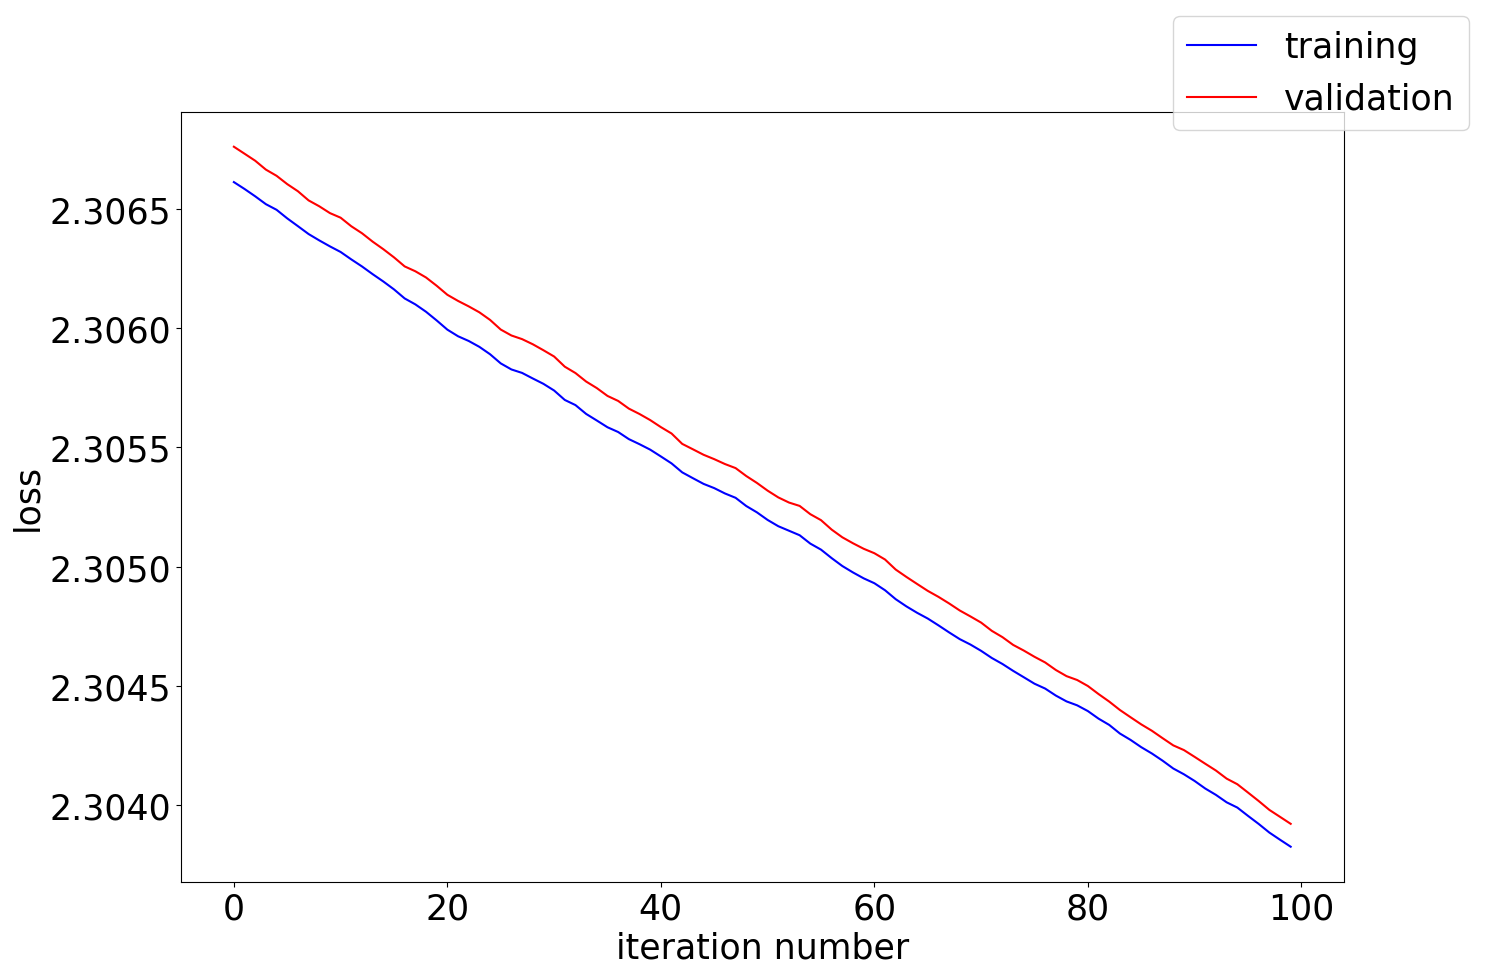


The total loss on the training data is 2.303824231100317

The classification loss (i.e. without weight decay) on the training data is 2.3004991010430778

The classification error rate on the training data is 0.9


The total loss on the validation data is 2.3039202732849087

The classification loss (i.e. without weight decay) on the validation data is 2.3005951432276692

The classification error rate on the validation data is 0.9


The total loss on the test data is 2.3035910482429216

The classification loss (i.e. without weight decay) on the test data is 2.300265918185682

The classification error rate on the test data is 0.9001111111111111


Running a2 with learning_rate=0.002 and momentum_multiplier=0.9
Now testing the gradient on the whole training set...
Gradient test passed for hid_to_class. 
Gradient test passed for input_to_hid. 
Gradient test passed. That means that the gradient that your code computed is within 0.001%% of the gradient that the finite difference approximation

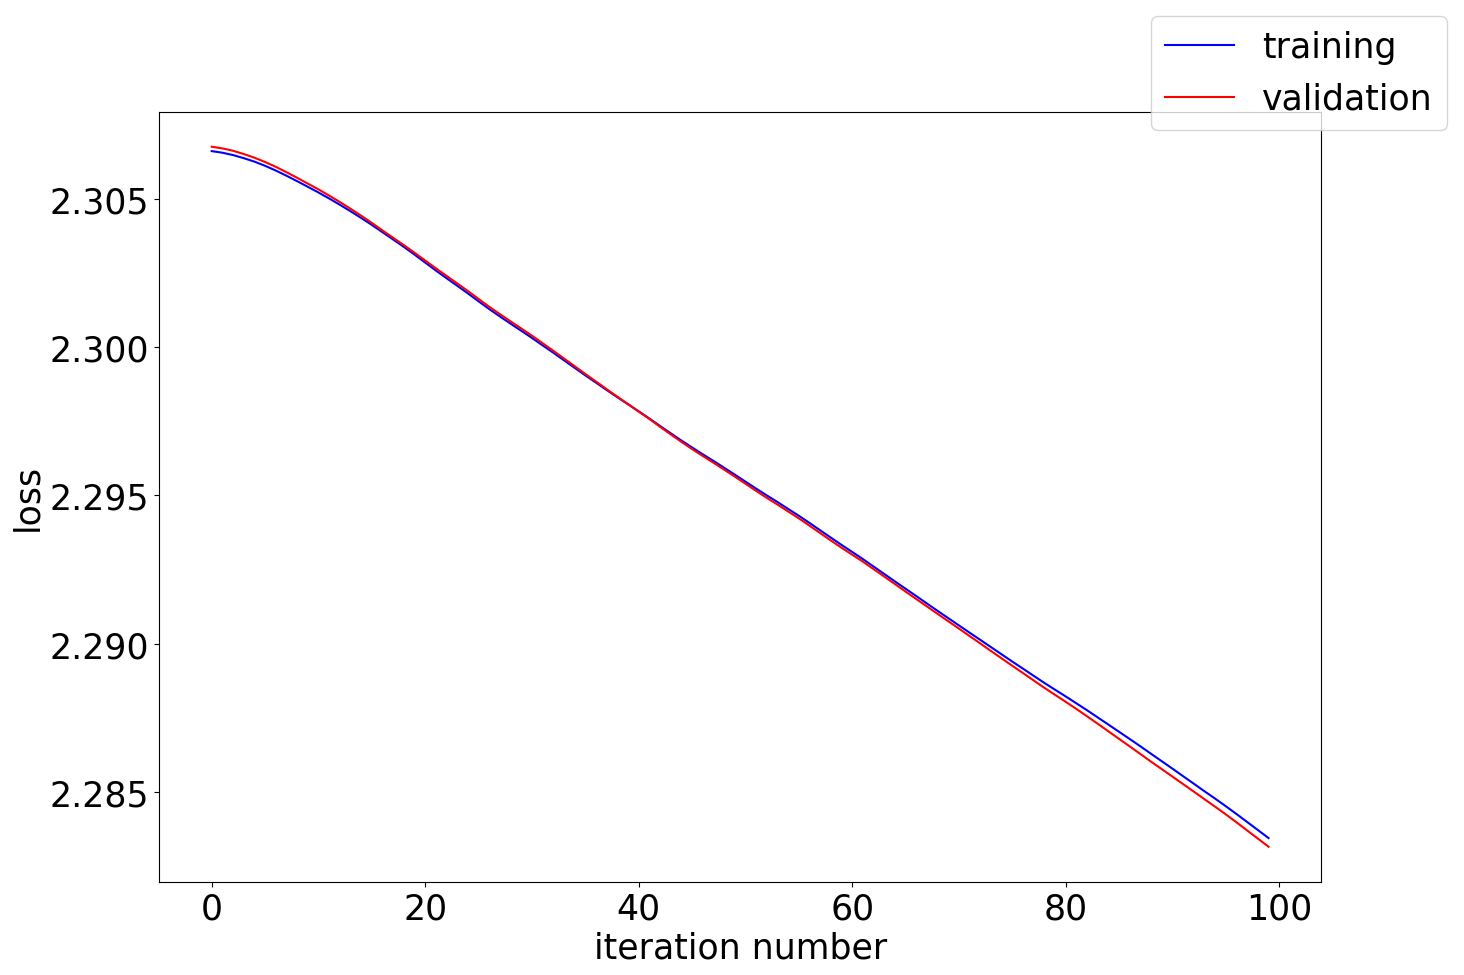


The total loss on the training data is 2.2834414901431774

The classification loss (i.e. without weight decay) on the training data is 2.2801139954809306

The classification error rate on the training data is 0.708


The total loss on the validation data is 2.2831495102949693

The classification loss (i.e. without weight decay) on the validation data is 2.2798220156327225

The classification error rate on the validation data is 0.714


The total loss on the test data is 2.2831691604242272

The classification loss (i.e. without weight decay) on the test data is 2.2798416657619804

The classification error rate on the test data is 0.725


Running a2 with learning_rate=0.01 and momentum_multiplier=0
Now testing the gradient on the whole training set...
Gradient test passed for hid_to_class. 
Gradient test passed for input_to_hid. 
Gradient test passed. That means that the gradient that your code computed is within 0.001%% of the gradient that the finite difference approximation computed,

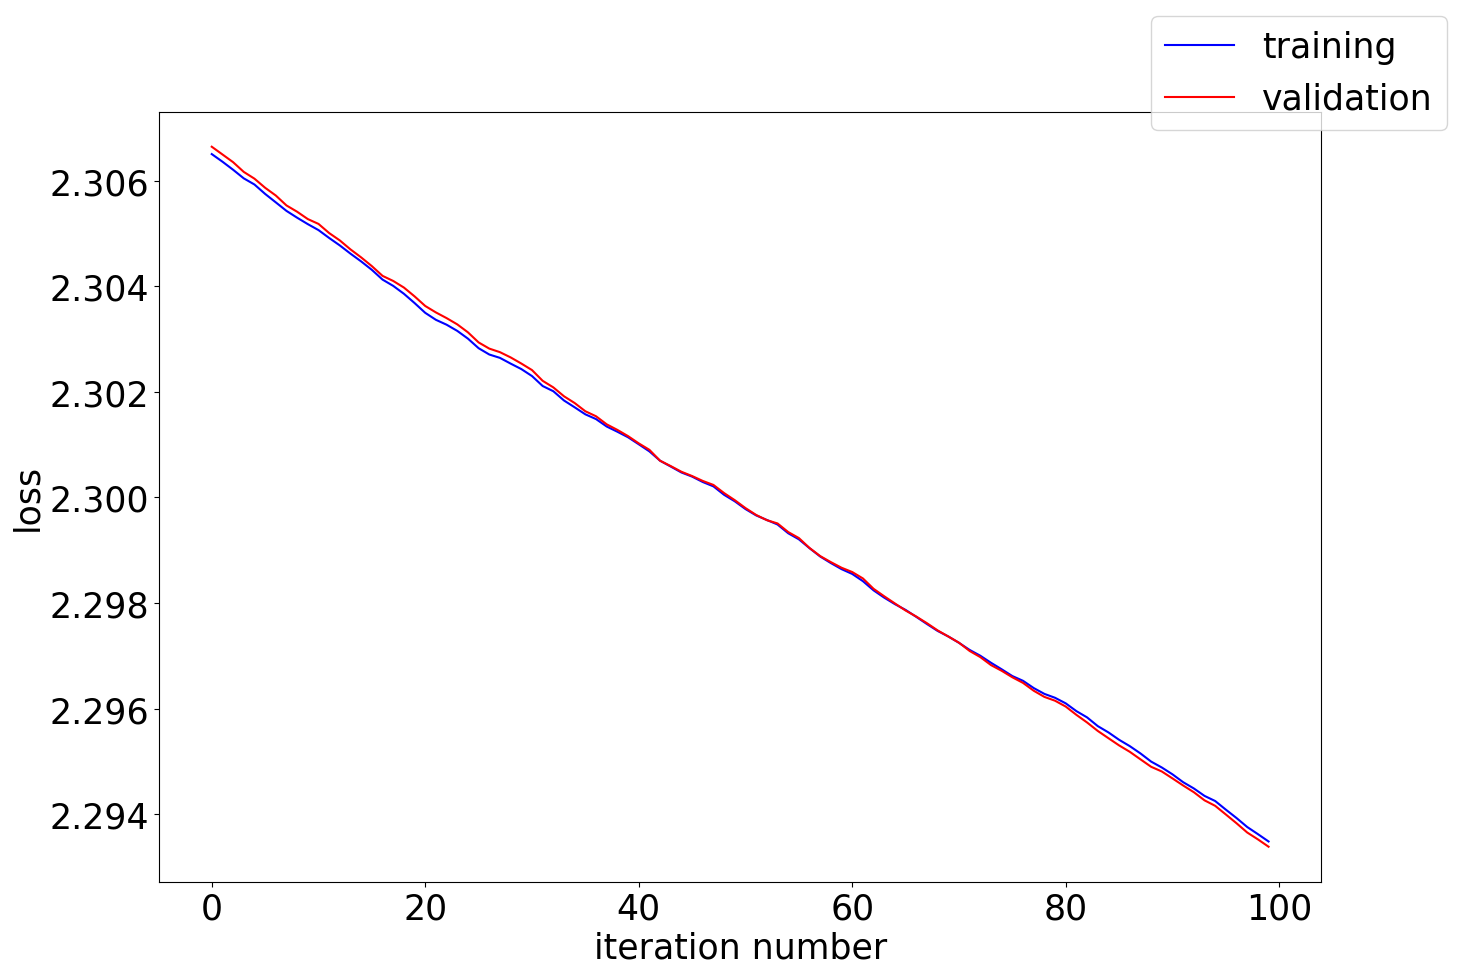


The total loss on the training data is 2.2934844555797995

The classification loss (i.e. without weight decay) on the training data is 2.290158745724578

The classification error rate on the training data is 0.754


The total loss on the validation data is 2.293385070358592

The classification loss (i.e. without weight decay) on the validation data is 2.2900593605033706

The classification error rate on the validation data is 0.764


The total loss on the test data is 2.2932241084418026

The classification loss (i.e. without weight decay) on the test data is 2.289898398586581

The classification error rate on the test data is 0.7566666666666667


Running a2 with learning_rate=0.01 and momentum_multiplier=0.9
Now testing the gradient on the whole training set...
Gradient test passed for hid_to_class. 
Gradient test passed for input_to_hid. 
Gradient test passed. That means that the gradient that your code computed is within 0.001%% of the gradient that the finite difference approximati

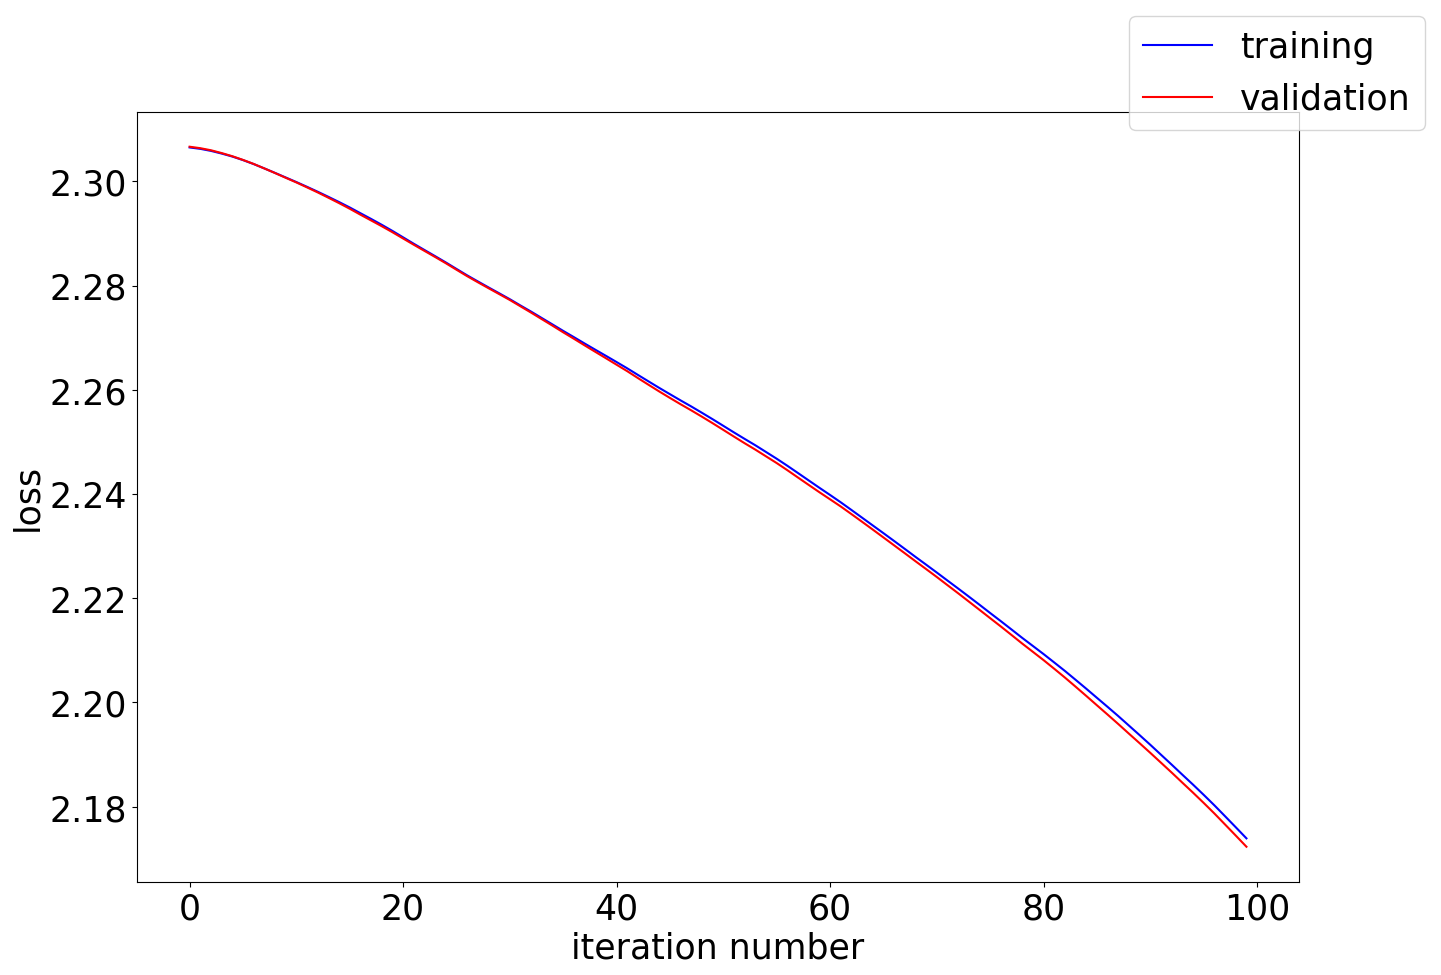


The total loss on the training data is 2.1739127593836005

The classification loss (i.e. without weight decay) on the training data is 2.170504104595808

The classification error rate on the training data is 0.669


The total loss on the validation data is 2.1723058235442716

The classification loss (i.e. without weight decay) on the validation data is 2.168897168756479

The classification error rate on the validation data is 0.67


The total loss on the test data is 2.1731866786892096

The classification loss (i.e. without weight decay) on the test data is 2.169778023901417

The classification error rate on the test data is 0.6816666666666666


Running a2 with learning_rate=0.05 and momentum_multiplier=0
Now testing the gradient on the whole training set...
Gradient test passed for hid_to_class. 
Gradient test passed for input_to_hid. 
Gradient test passed. That means that the gradient that your code computed is within 0.001%% of the gradient that the finite difference approximation 

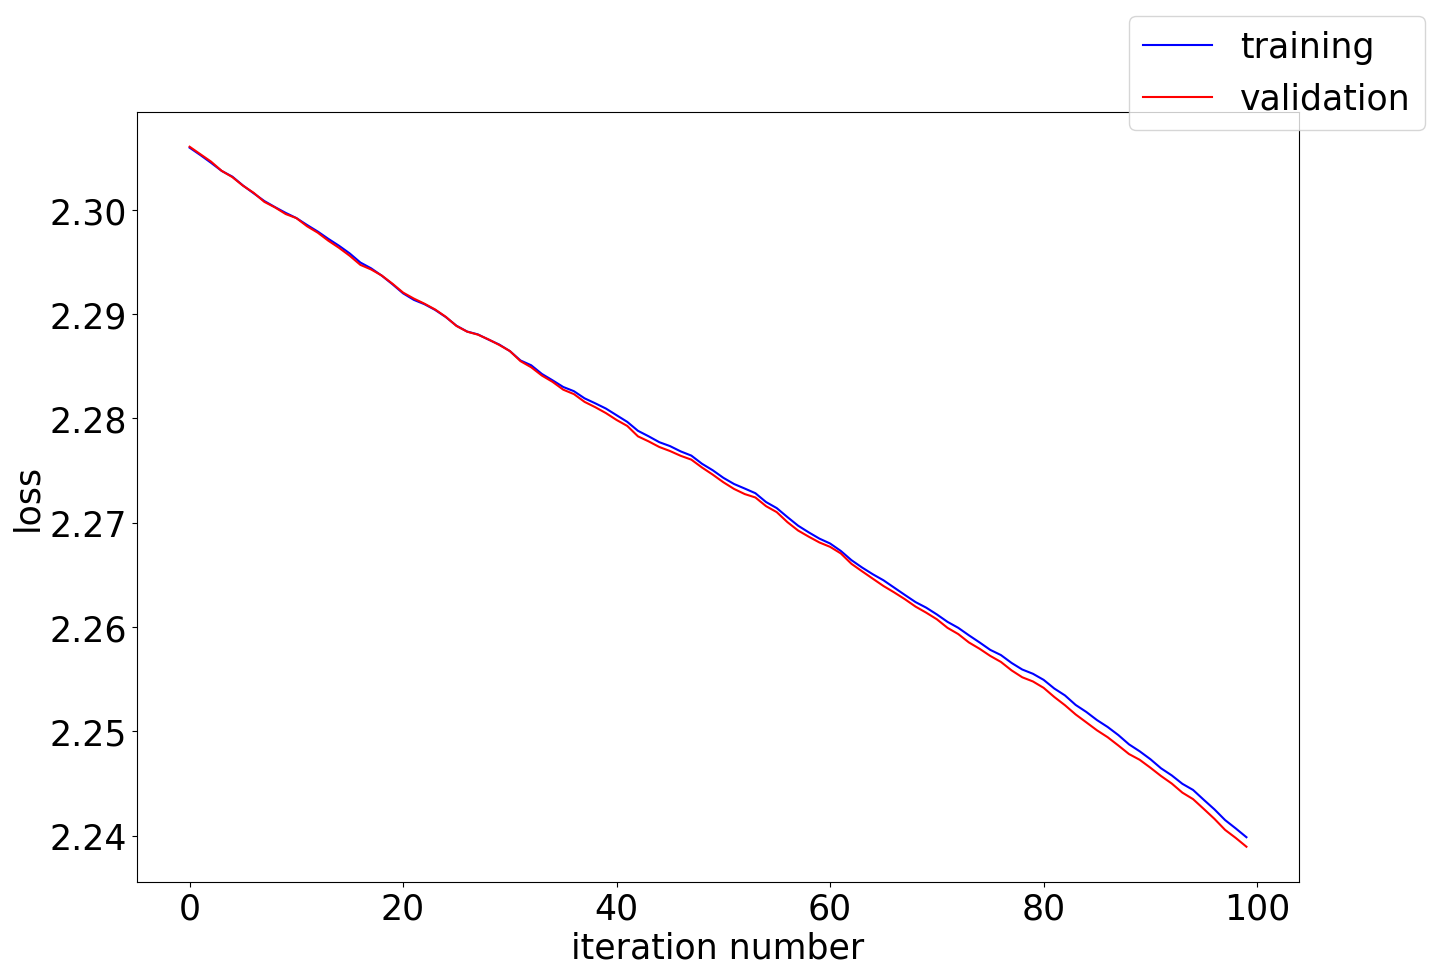


The total loss on the training data is 2.2398476108370904

The classification loss (i.e. without weight decay) on the training data is 2.2364962971699667

The classification error rate on the training data is 0.681


The total loss on the validation data is 2.2389362070994774

The classification loss (i.e. without weight decay) on the validation data is 2.2355848934323537

The classification error rate on the validation data is 0.694


The total loss on the test data is 2.2394256539342536

The classification loss (i.e. without weight decay) on the test data is 2.23607434026713

The classification error rate on the test data is 0.7025555555555556


Running a2 with learning_rate=0.05 and momentum_multiplier=0.9
Now testing the gradient on the whole training set...
Gradient test passed for hid_to_class. 
Gradient test passed for input_to_hid. 
Gradient test passed. That means that the gradient that your code computed is within 0.001%% of the gradient that the finite difference approximat

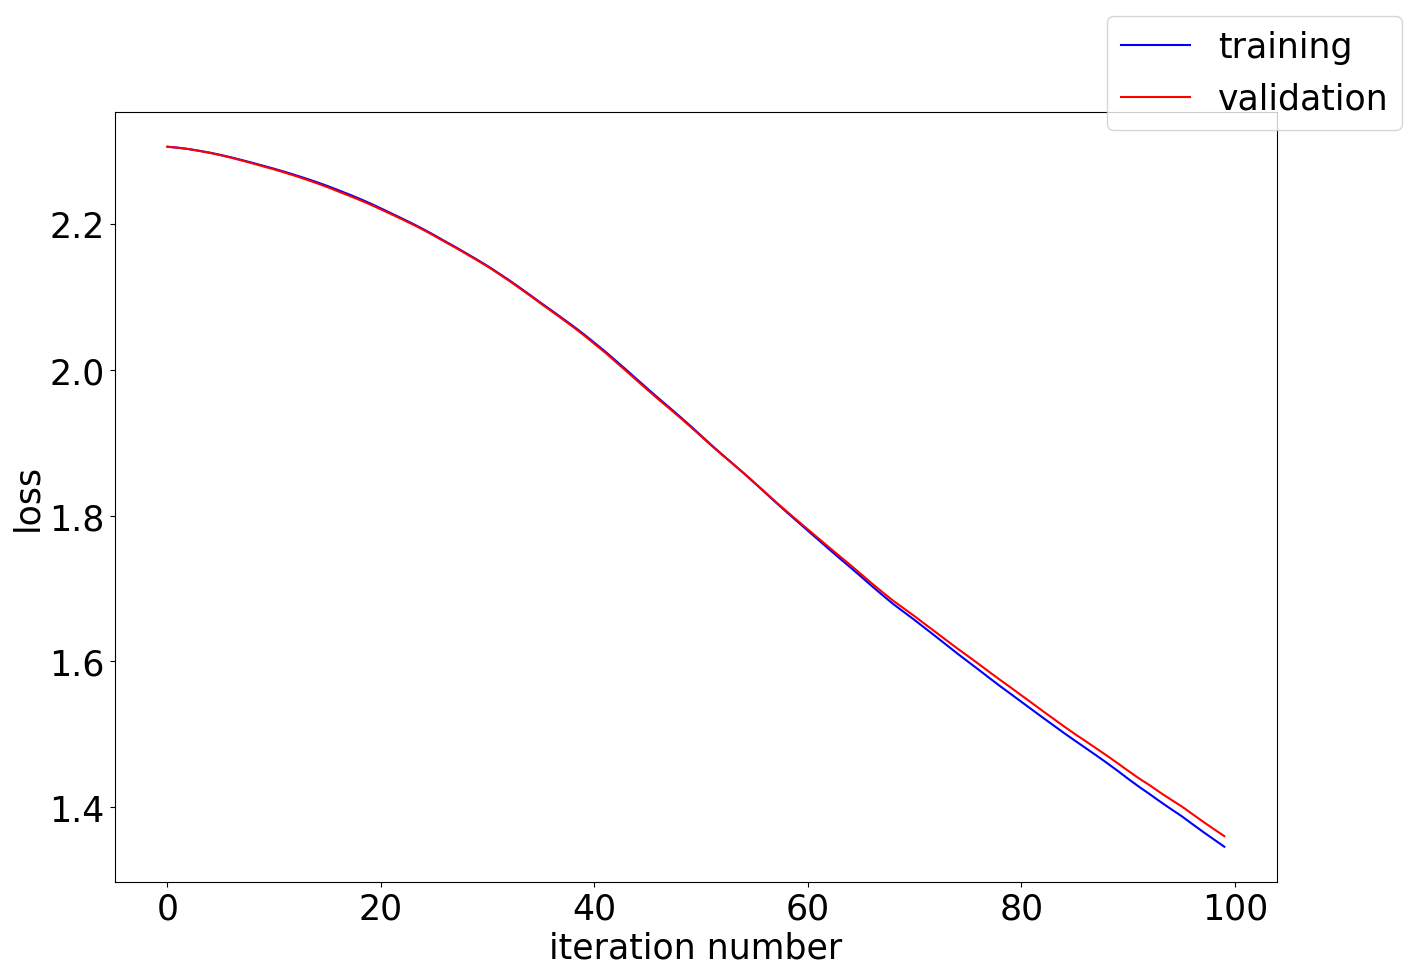


The total loss on the training data is 1.3457837551756977

The classification loss (i.e. without weight decay) on the training data is 1.3403030616038065

The classification error rate on the training data is 0.396


The total loss on the validation data is 1.3603344989343396

The classification loss (i.e. without weight decay) on the validation data is 1.3548538053624484

The classification error rate on the validation data is 0.409


The total loss on the test data is 1.3435354670895752

The classification loss (i.e. without weight decay) on the test data is 1.338054773517684

The classification error rate on the test data is 0.405


Running a2 with learning_rate=0.2 and momentum_multiplier=0
Now testing the gradient on the whole training set...
Gradient test passed for hid_to_class. 
Gradient test passed for input_to_hid. 
Gradient test passed. That means that the gradient that your code computed is within 0.001%% of the gradient that the finite difference approximation computed, s

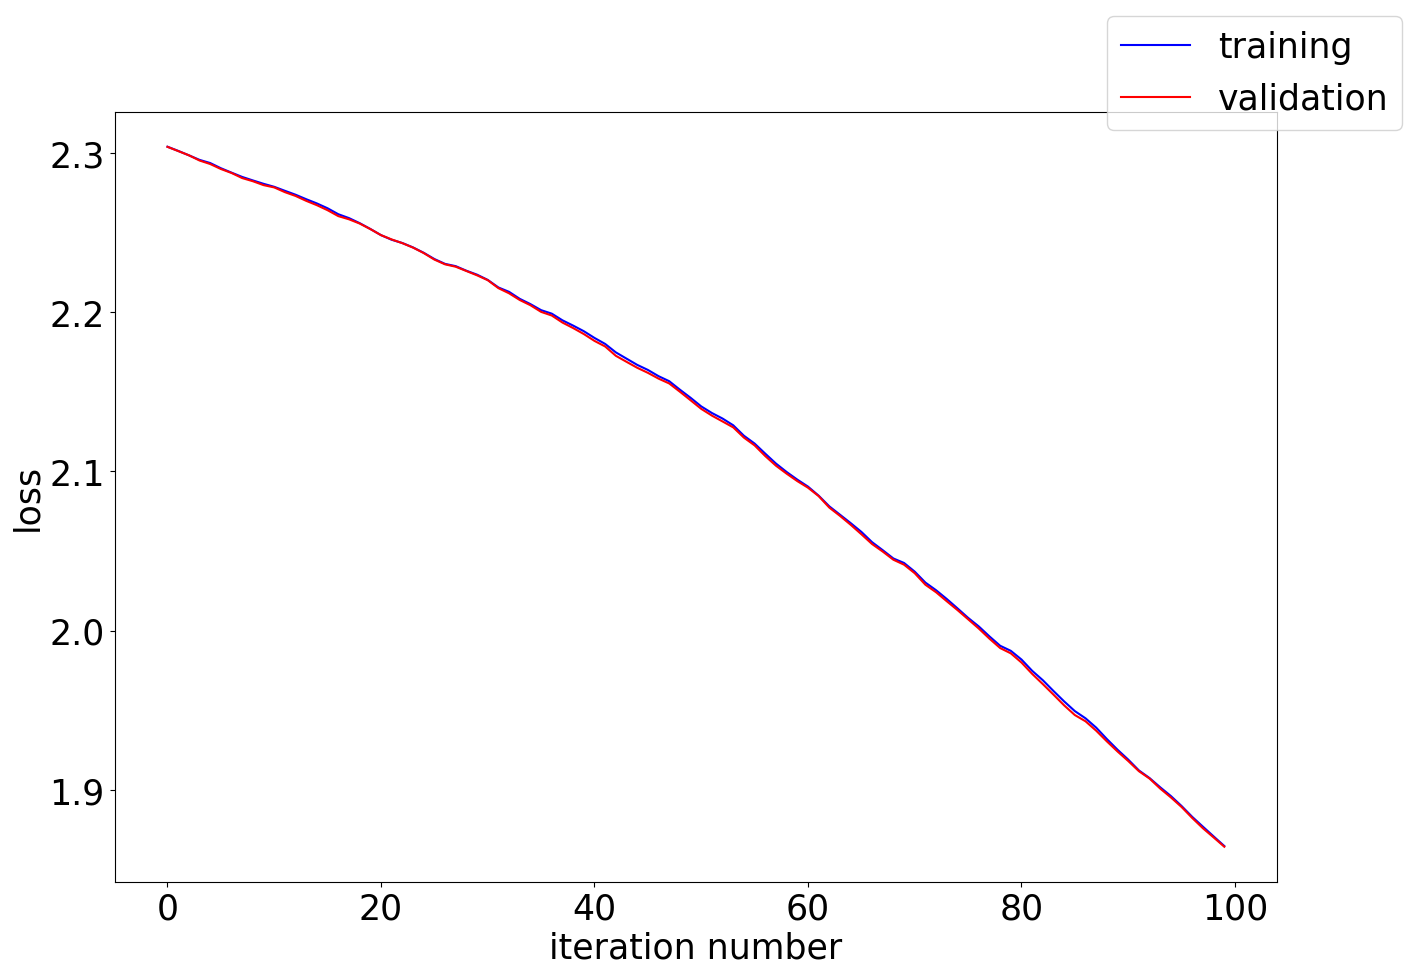


The total loss on the training data is 1.8646370611512482

The classification loss (i.e. without weight decay) on the training data is 1.8607716244617327

The classification error rate on the training data is 0.581


The total loss on the validation data is 1.8641993127247702

The classification loss (i.e. without weight decay) on the validation data is 1.8603338760352548

The classification error rate on the validation data is 0.585


The total loss on the test data is 1.8599894237172148

The classification loss (i.e. without weight decay) on the test data is 1.8561239870276993

The classification error rate on the test data is 0.5848888888888889


Running a2 with learning_rate=0.2 and momentum_multiplier=0.9
Now testing the gradient on the whole training set...
Gradient test passed for hid_to_class. 
Gradient test passed for input_to_hid. 
Gradient test passed. That means that the gradient that your code computed is within 0.001%% of the gradient that the finite difference approxima

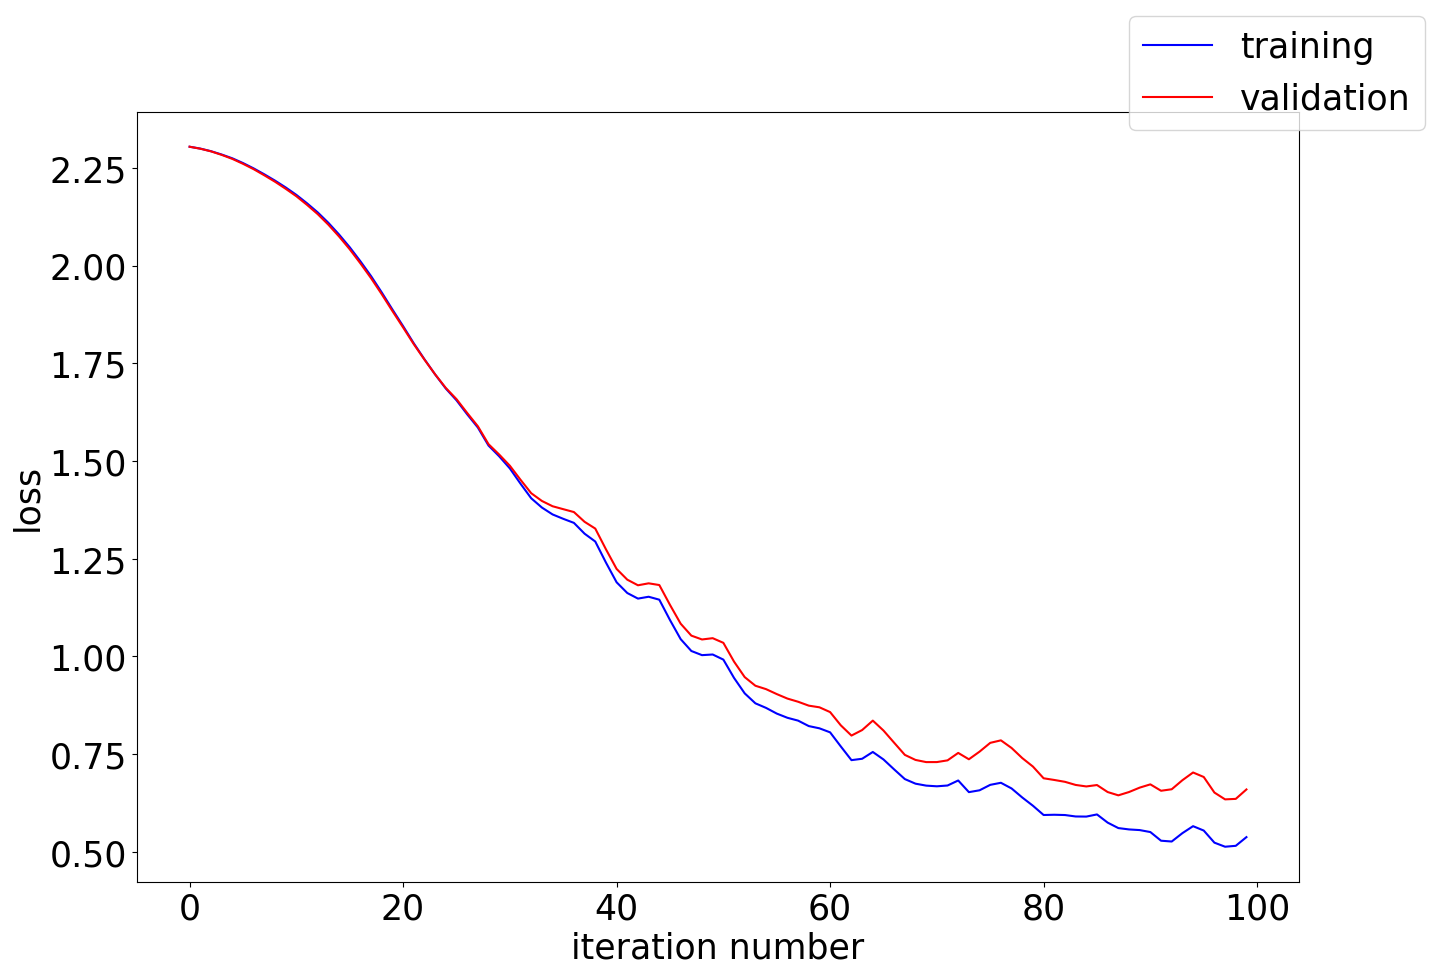


The total loss on the training data is 0.5132863629302705

The classification loss (i.e. without weight decay) on the training data is 0.49688709332161807

The classification error rate on the training data is 0.165


The total loss on the validation data is 0.6344054218171142

The classification loss (i.e. without weight decay) on the validation data is 0.6180061522084618

The classification error rate on the validation data is 0.203


The total loss on the test data is 0.6076288834957079

The classification loss (i.e. without weight decay) on the test data is 0.5912296138870554

The classification error rate on the test data is 0.189


Running a2 with learning_rate=1.0 and momentum_multiplier=0
Now testing the gradient on the whole training set...
Gradient test passed for hid_to_class. 
Gradient test passed for input_to_hid. 
Gradient test passed. That means that the gradient that your code computed is within 0.001%% of the gradient that the finite difference approximation computed,

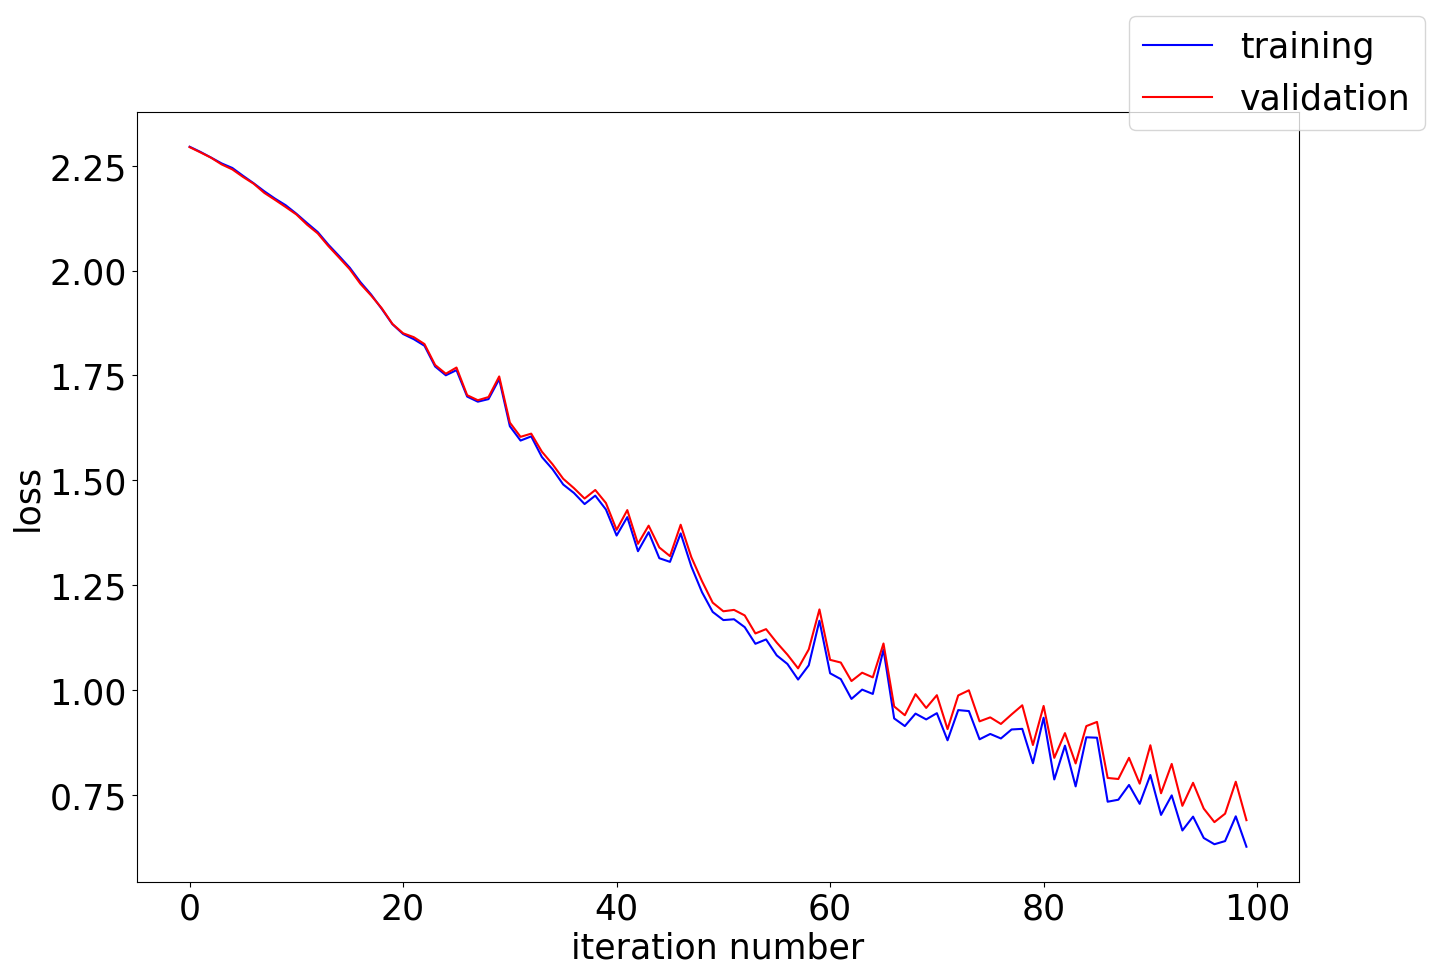


The total loss on the training data is 0.6323794683623022

The classification loss (i.e. without weight decay) on the training data is 0.6223404731314566

The classification error rate on the training data is 0.179


The total loss on the validation data is 0.6850964276763187

The classification loss (i.e. without weight decay) on the validation data is 0.6750574324454731

The classification error rate on the validation data is 0.206


The total loss on the test data is 0.667375932554453

The classification loss (i.e. without weight decay) on the test data is 0.6573369373236074

The classification error rate on the test data is 0.1948888888888889


Running a2 with learning_rate=1.0 and momentum_multiplier=0.9
Now testing the gradient on the whole training set...
Gradient test passed for hid_to_class. 
Gradient test passed for input_to_hid. 
Gradient test passed. That means that the gradient that your code computed is within 0.001%% of the gradient that the finite difference approximat

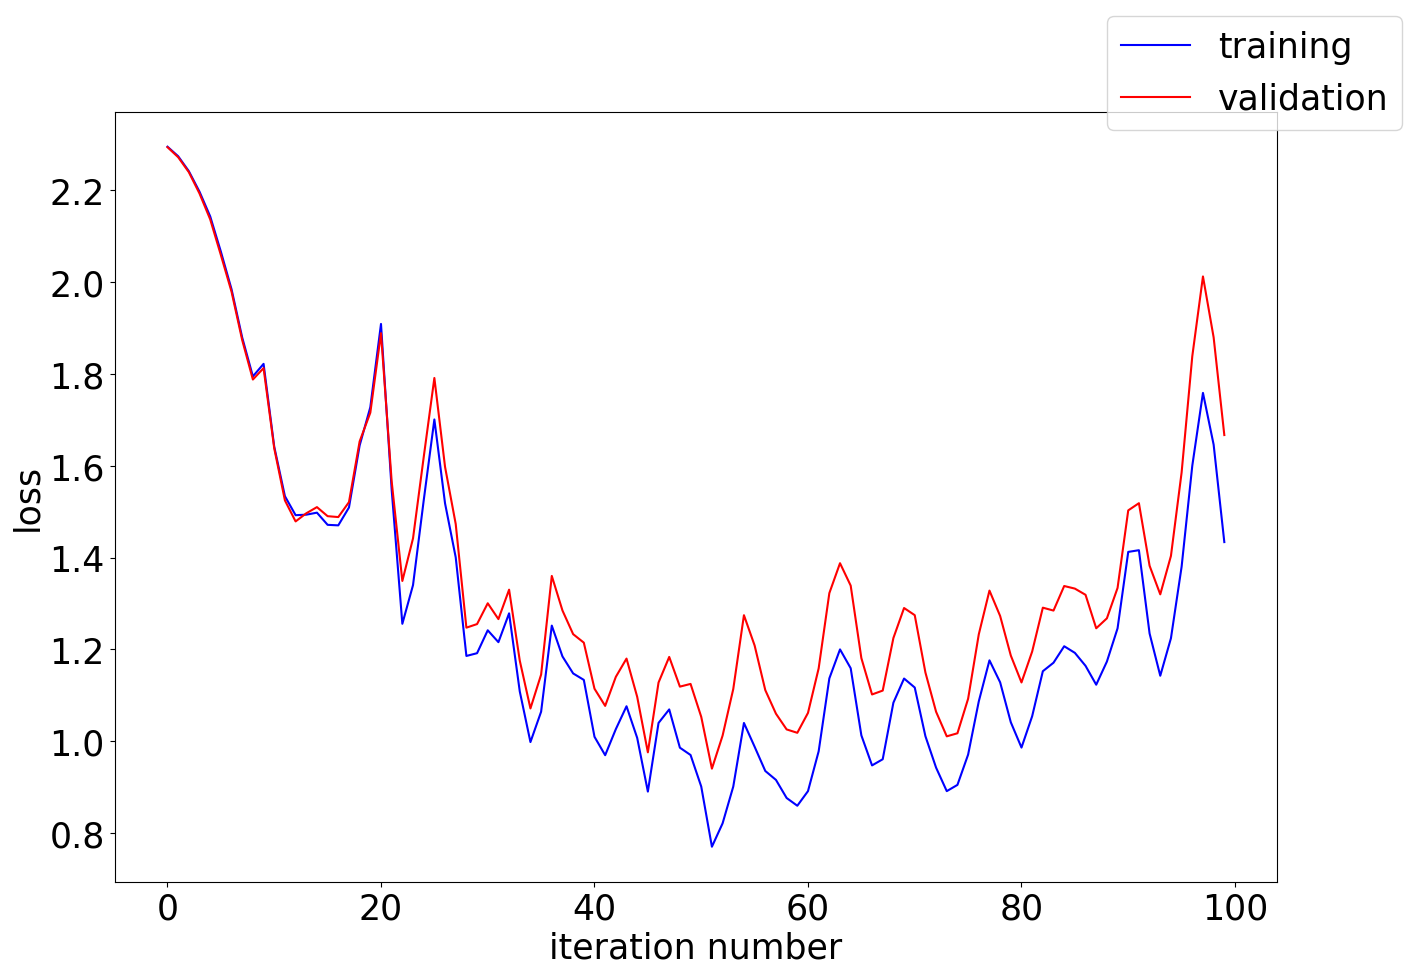


The total loss on the training data is 0.7703126098283415

The classification loss (i.e. without weight decay) on the training data is 0.6616052581467627

The classification error rate on the training data is 0.22


The total loss on the validation data is 0.940396012254018

The classification loss (i.e. without weight decay) on the validation data is 0.8316886605724393

The classification error rate on the validation data is 0.251


The total loss on the test data is 0.8775824683623481

The classification loss (i.e. without weight decay) on the test data is 0.7688751166807694

The classification error rate on the test data is 0.2528888888888889


Running a2 with learning_rate=5.0 and momentum_multiplier=0
Now testing the gradient on the whole training set...
Gradient test passed for hid_to_class. 
Gradient test passed for input_to_hid. 
Gradient test passed. That means that the gradient that your code computed is within 0.001%% of the gradient that the finite difference approximation

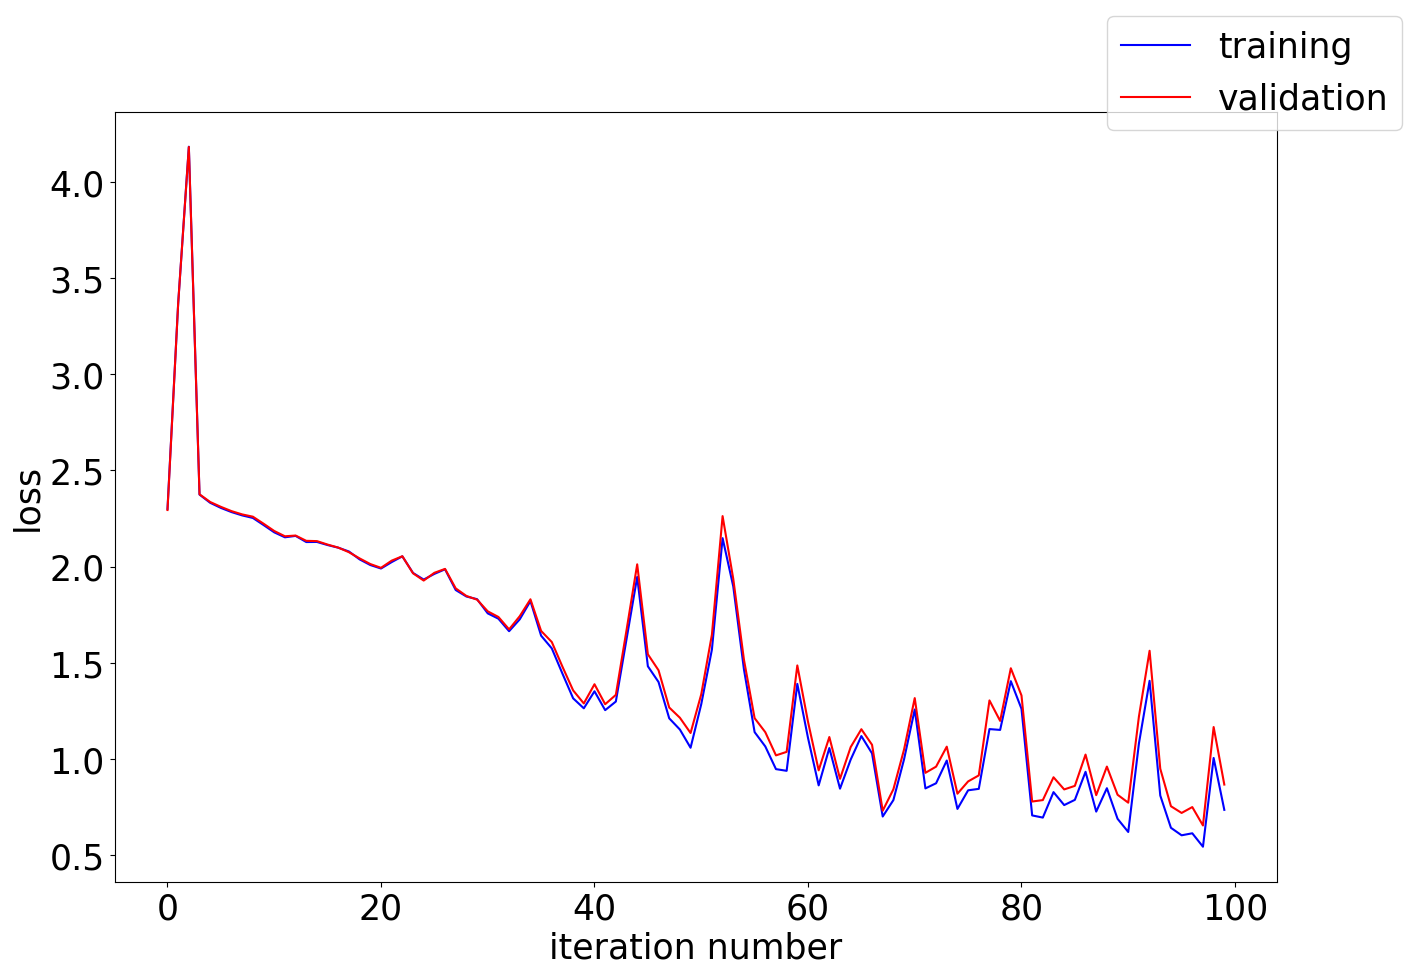


The total loss on the training data is 0.5418927188469397

The classification loss (i.e. without weight decay) on the training data is 0.49045571493018075

The classification error rate on the training data is 0.147


The total loss on the validation data is 0.6524785132202452

The classification loss (i.e. without weight decay) on the validation data is 0.6010415093034862

The classification error rate on the validation data is 0.188


The total loss on the test data is 0.64633131378158

The classification loss (i.e. without weight decay) on the test data is 0.5948943098648211

The classification error rate on the test data is 0.18788888888888888


Running a2 with learning_rate=5.0 and momentum_multiplier=0.9
Now testing the gradient on the whole training set...
Gradient test passed for hid_to_class. 
Gradient test passed for input_to_hid. 
Gradient test passed. That means that the gradient that your code computed is within 0.001%% of the gradient that the finite difference approxima

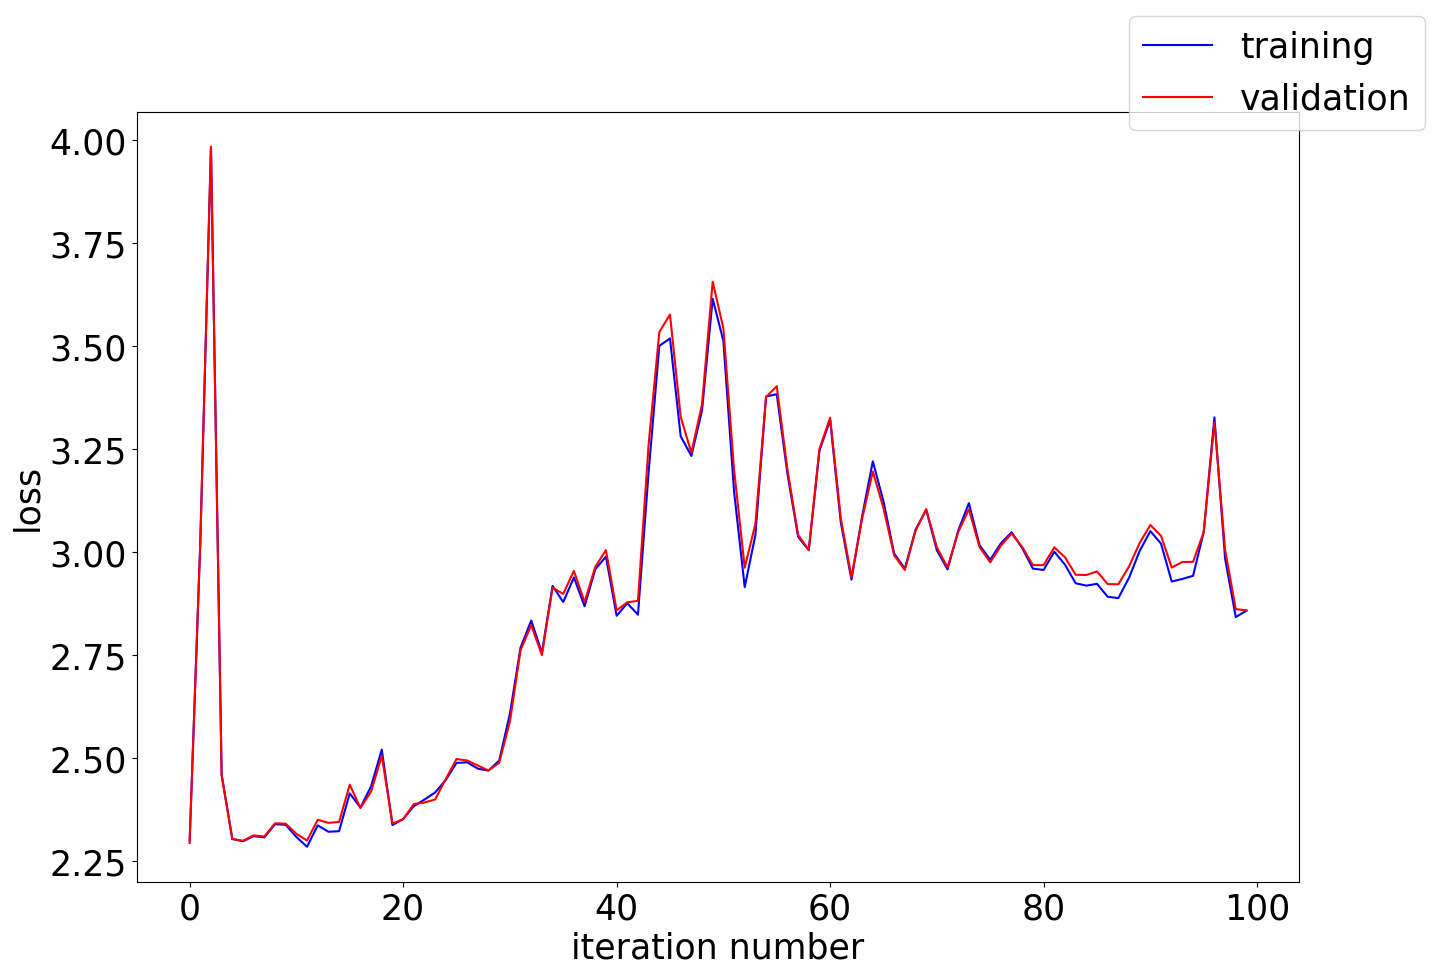


The total loss on the training data is 2.299739692206897

The classification loss (i.e. without weight decay) on the training data is 2.296311579583822

The classification error rate on the training data is 0.92


The total loss on the validation data is 2.2940845725217844

The classification loss (i.e. without weight decay) on the validation data is 2.2906564598987096

The classification error rate on the validation data is 0.919


The total loss on the test data is 2.291849734540491

The classification loss (i.e. without weight decay) on the test data is 2.2884216219174163

The classification error rate on the test data is 0.9088888888888889


Running a2 with learning_rate=20.0 and momentum_multiplier=0
Now testing the gradient on the whole training set...
Gradient test passed for hid_to_class. 
Gradient test passed for input_to_hid. 
Gradient test passed. That means that the gradient that your code computed is within 0.001%% of the gradient that the finite difference approximation 

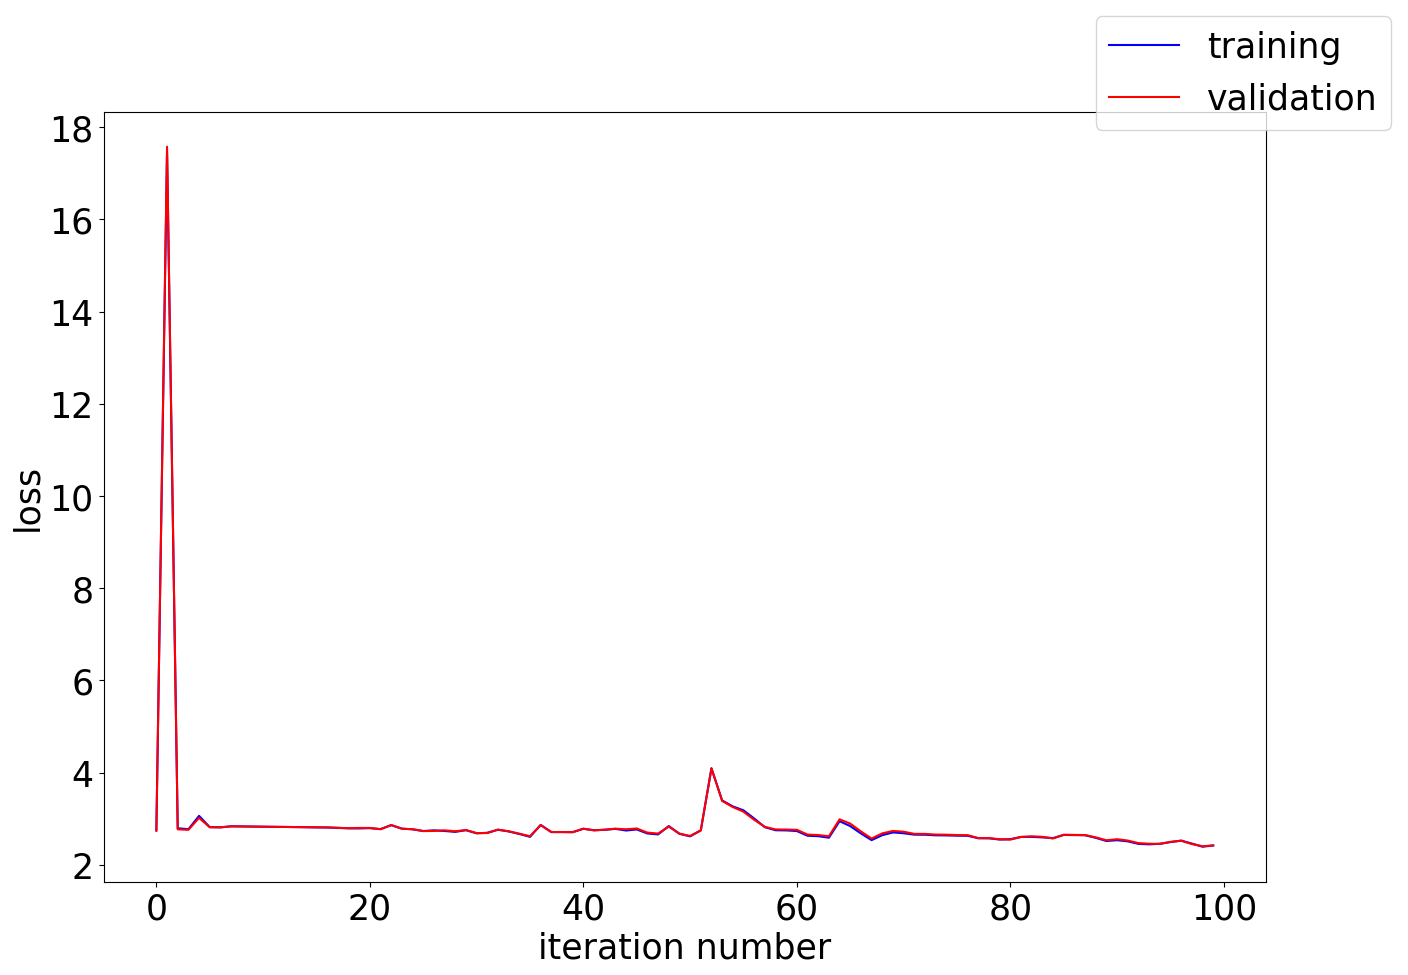


The total loss on the training data is 2.3936565787164947

The classification loss (i.e. without weight decay) on the training data is 1.9814185349450568

The classification error rate on the training data is 0.79


The total loss on the validation data is 2.4044134476014536

The classification loss (i.e. without weight decay) on the validation data is 1.992175403830016

The classification error rate on the validation data is 0.807


The total loss on the test data is 2.4117479398976576

The classification loss (i.e. without weight decay) on the test data is 1.9995098961262197

The classification error rate on the test data is 0.7955555555555556


Running a2 with learning_rate=20.0 and momentum_multiplier=0.9
Now testing the gradient on the whole training set...
Gradient test passed for hid_to_class. 
Gradient test passed for input_to_hid. 
Gradient test passed. That means that the gradient that your code computed is within 0.001%% of the gradient that the finite difference approximat

/notebooks/ComputerVision/HW9/utils.py:50: RuntimeWarning: overflow encountered in exp
  ret = 1 / (1 + np.exp(-input))


After 70 optimization iterations, training data loss is 6.704515666209893, and validation data loss is 6.704870708940403

After 80 optimization iterations, training data loss is 4.969227723579632, and validation data loss is 4.968880900103409

After 90 optimization iterations, training data loss is 4.526209483094469, and validation data loss is 4.543935988951166

After 100 optimization iterations, training data loss is 5.230588522945585, and validation data loss is 5.237759916160097

Now testing the gradient on just a mini-batch instead of the whole training set... 
Gradient test passed for hid_to_class. 
Gradient test passed for input_to_hid. 
Gradient test passed. That means that the gradient that your code computed is within 0.001%% of the gradient that the finite difference approximation computed, so the gradient calculation procedure is probably correct (not certainly, but probably).

Early stopping: validation loss was lowest after 1 iterations. We chose the model that we had the

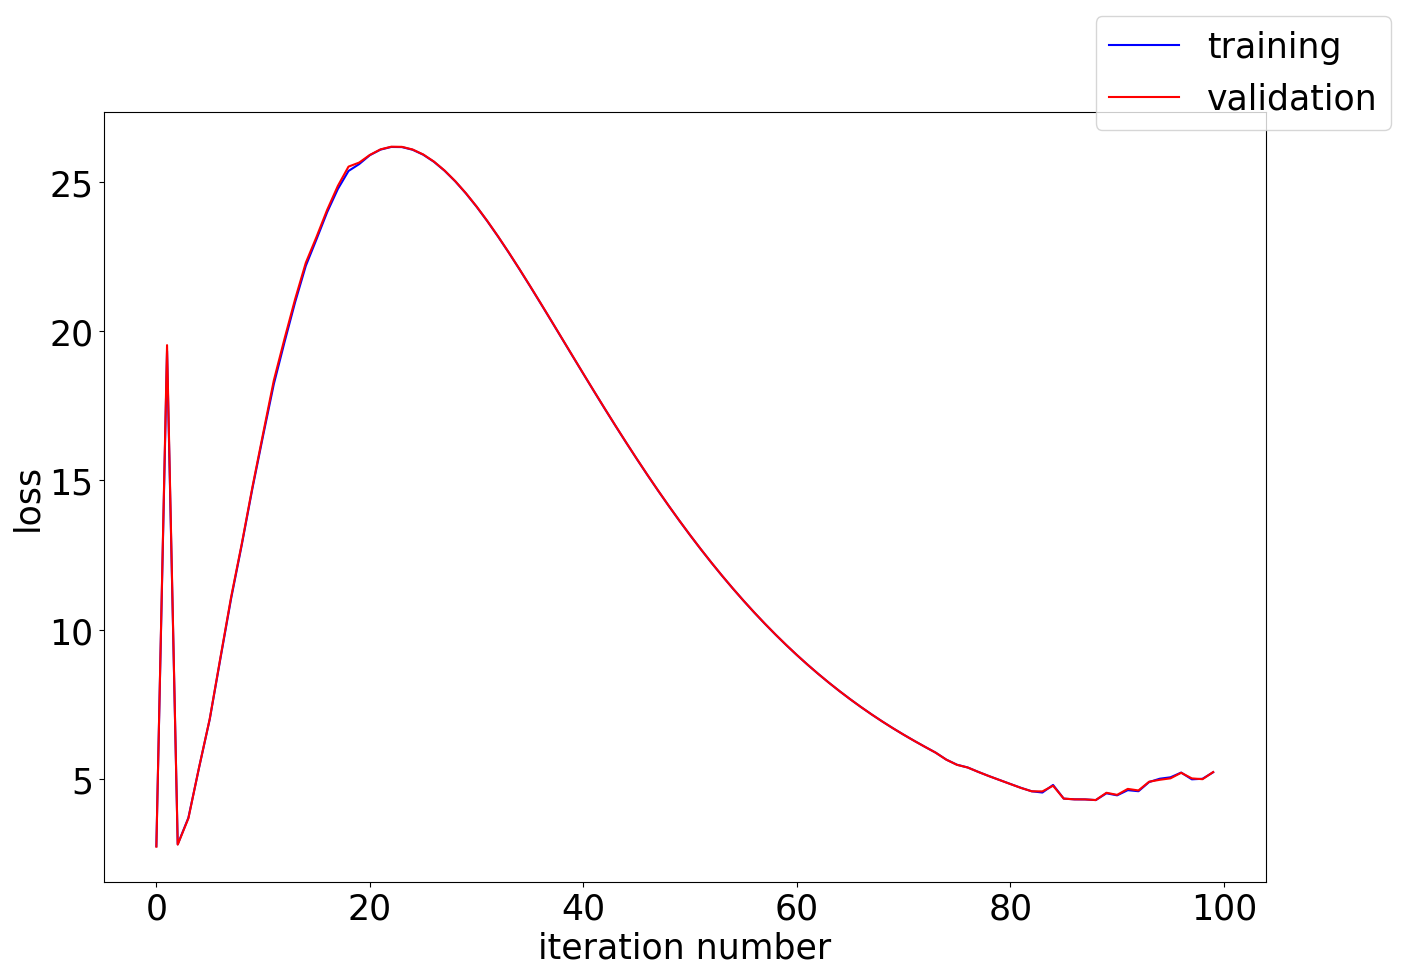


The total loss on the training data is 2.758743841110097

The classification loss (i.e. without weight decay) on the training data is 2.753747837714326

The classification error rate on the training data is 0.928


The total loss on the validation data is 2.737106890254882

The classification loss (i.e. without weight decay) on the validation data is 2.732110886859111

The classification error rate on the validation data is 0.926


The total loss on the test data is 2.7338713744875527

The classification loss (i.e. without weight decay) on the test data is 2.7288753710917817

The classification error rate on the test data is 0.9157777777777778



In [7]:
#try with learning_rate = 0.002, 0.01, 0.05, 0.2, 1.0, 5.0, and 20.0, and with and without momentum_multiplier=0.9

learning_rates = [0.002, 0.01, 0.05, 0.2, 1.0, 5.0, 20.0]
momentum_multipliers = [0, 0.9] 

for lr in learning_rates:
    for momentum in momentum_multipliers:
        print(f"\nRunning a2 with learning_rate={lr} and momentum_multiplier={momentum}")
        a2(
            wd_coefficient=0.0001,  
            n_hid=50,                  
            n_iters=100,              
            learning_rate=lr,
            momentum_multiplier=momentum,
            do_early_stopping=True,   
            mini_batch_size=10         
        )
